In [1]:
import math
ln2 = math.log(2)
def ln2over(t):
    return ln2/t
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import ode

In [ ]:
# Note, this example uses Cp(0) = Cp(t0)
Cptimes = np.asarray([-13.95, 0, 5.33, 10.5, 12.53, 15.1, 19.25, 24.1, 30.1, 45.13, 60.13, 90.3, 128.48])
Cpsamples = np.asarray([0,0,902.81, 2780.19, 2965.27, 2015.83, 1489.56, 1232.83, 971.8, 833.71, 707.99, 631.24, 552.62])

In [38]:
testtimes  = np.asarray([ -1, 0,  1,  2,  3,  5,  17])
testlevels = np.asarray([ 10, 2,100,250,600,900,2200])
testtimes2 = np.asarray([-10, 0,  1,  4,  6, 17,  117])
wherelist = [testtimes2[:-1]<testtimes[1:]]
testlevels[np.append(testtimes2[0]<0,wherelist)]

array([ 10,   2, 100, 250])

**Waah.** That is not what I want. Forget this.

In [45]:
-1e23 > np.NINF

True

In [153]:
def correct_bloods(Cptimes, Cpsamples, insert_zero=True, beta=0):
    """ Check blood sample times for sensible timing. Optionally add
        a sample at time zero if none was drawn but a sample was drawn
        at time t<0. If beta > 0, correct this inserted point for 
        elimination.
    Cptimes: numpy array of times when blood was drawn
    Cpsamples: plasma concentrations at those times
    beta: terminal phase (elimination) rate constant = ln(2)/t1/2.
        Default 0 (no elimination).
    insert_zero: as above.
    Returns: new versions of Cptimes, Cpsamples
    """
    assert (Cptimes.size == Cpsamples.size), \
        "Sizes of Cptimes ({0}) and Cpsamples ({1}) arrays differ".format(Cptimes.size, Cpsamples.size)
    assert (np.all(Cptimes[1:] > Cptimes[:-1])), \
        "Cptimes not in strictly ascending order at index {0}".format(np.argmax(Cptimes[1:]<=Cptimes[:-1]))
    latest_neg = -1  # i.e. there is no t<0 so we can't correct for elimination
    no_t_0 = True
    for i in range(Cptimes.size):
        if Cptimes[i]<0: 
            if i>latest_neg:
                latest_neg = i
            if i==Cptimes.size-1 and insert_zero:
                # this is the last entry and t<0, so we have to append to the end
                Cptimes = np.append(Cptimes,0)
                Cpsamples = np.append(Cpsamples,Cpsamples[-1]*math.exp(beta*Cptimes[i]))
        elif Cptimes[i] == 0:
            no_t_0 = False
        else:  # Cptimes[i]>0
            if i==1+latest_neg and insert_zero and latest_neg>-1:
                # this is the first non-negative time after a negative time
                Cptimes = np.insert(Cptimes,i,0)
                Cpsamples = np.insert(Cpsamples,i,Cpsamples[i-1]*math.exp(beta*Cptimes[i-1]))
#    print('Got here.')
    return Cptimes, Cpsamples

In [154]:
testtimes3 = np.asarray([-10,-5,-1])
testlevels3 = np.asarray([100,50,30])
testtimes4 = np.asarray([-10,10,20])
testlevels4 = np.asarray([50,2000,1000])
print(testtimes, testlevels)
print(correct_bloods(testtimes,testlevels))
print()
print(testtimes3, testlevels3)
print(correct_bloods(testtimes3,testlevels3))
print(correct_bloods(testtimes3,testlevels3, beta=ln2over(5)))
print()
print(testtimes4, testlevels4)
print(correct_bloods(testtimes4, testlevels4))
print(correct_bloods(testtimes4, testlevels4, beta=ln2over(5)))

[-1  0  1  2  3  5 17] [  10    2  100  250  600  900 2200]
(array([-1,  0,  1,  2,  3,  5, 17]), array([  10,    2,  100,  250,  600,  900, 2200]))

[-10  -5  -1] [100  50  30]
(array([-10,  -5,  -1,   0]), array([ 100.,   50.,   30.,   30.]))
(array([-10,  -5,  -1,   0]), array([ 100.       ,   50.       ,   30.       ,   26.1165169]))

[-10  10  20] [  50 2000 1000]
(array([-10,   0,  10,  20]), array([  50,   50, 2000, 1000]))
(array([-10,   0,  10,  20]), array([  50,   12, 2000, 1000]))


### Those test cases are correct.

In [177]:
debug = False
def Cp(t, Cptimes, Cpsamples, beta=0, Cinf=0):  # numpy arrays
    """ Return a numpy array of estimated plasma levels at times t, based on
        known plasma concentrations Cpsamples at times Cptimes.
        WARNING: Assumes input has been cleaned with correct_bloods.
    t: numpy array of times
    Cptimes: times when blood was drawn
    Cpsamples: plasma concentrations at those times
    beta: terminal phase (elimination) rate constant = ln(2)/t1/2. Default 0 (constant).
    Cinf: for studies with constant infusion rate after some time, Cp(infinity)
    """
    tmin = Cptimes[ 0]-20
    assert (np.amin(t)>tmin), "Cp(t) evaluated at t={0}".format(np.amin(t))
    tmax = Cptimes[-1]+20
    assert (np.amax(t)<tmax), "Cp(t) evaluated at t={0}".format(np.amax(t))
    def m(i):  # scalar
        return (Cpsamples[i+1]-Cpsamples[i])/(Cptimes[i+1]-Cptimes[i])
#    result = np.piecewise(t, 
#                          [ t<Cptimes[1],t>=Cptimes[1] and t<Cptimes[2], ... ],
#                          [list of functions applied to t, or scalars],
#                          (arguments passed to functions), 
#                          (keyword arguments passed to functions)
#                         )
    result = np.zeros_like(t)
    for i in range(Cptimes.size-1):
        mask = np.logical_and(t>=Cptimes[i],t<Cptimes[i+1])
        result[ mask ] = \
            Cpsamples[i] + m(i)*(t[mask]-Cptimes[i]) # for most values of t
    # for values outside the range sampled, estimate based on supplied elimination rate:
    if debug:
        print('t[t<Cptimes[ 0]] =', t[t<Cptimes[ 0]])
        print('Cptimes[0] =', Cptimes[0])
        print('beta =',beta)
        print('-beta*(t[t<Cptimes[ 0]]-Cptimes[ 0]) =',-beta*(t[t<Cptimes[ 0]]-Cptimes[ 0]))
    result[t<Cptimes[ 0]] = Cpsamples[ 0]*np.exp(-beta*(t[t<Cptimes[ 0]]-Cptimes[ 0]))
    result[t>Cptimes[-1]] = Cinf + (Cpsamples[-1]-Cinf)*np.exp(-beta*(t[t>Cptimes[-1]]-Cptimes[-1]))
    return result

In [178]:
Cptimes1 = np.asarray([-13.95, 5.33, 10.5, 12.53, 15.1, 19.25, 24.1, 30.1, 45.13, 60.13, 90.3, 128.48])
Cpsamples1 = np.asarray([100,902.81, 2780.19, 2965.27, 2015.83, 1489.56, 1232.83, 971.8, 833.71, 707.99, 631.24, 552.62])
beta = ln2over(5)
Cinf = 550
Cptimes, Cpsamples = correct_bloods(Cptimes1, Cpsamples1, beta=beta)
print('  t', '\t', ' Cp(t) ')
print('=====', '\t', '=======')
readouts = np.linspace(-20,130,1+(130-(-20))//10)
for x in readouts:
    print('{0:>5.1f}\t{1:>8.2f}'.format(np.asscalar(x),
                                        np.asscalar(Cp(x,Cptimes,Cpsamples,beta=beta,Cinf=Cinf))))

  t 	  Cp(t) 
===== 	 =======
-20.0	  231.34
-10.0	   75.78
  0.0	   14.46
 10.0	 2598.63
 20.0	 1449.86
 30.0	  976.15
 40.0	  880.84
 50.0	  792.89
 60.0	  709.08
 70.0	  682.88
 80.0	  657.44
 90.0	  632.00
100.0	  611.27
110.0	  590.67
120.0	  570.08
130.0	  552.12


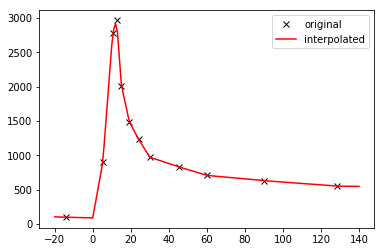

In [191]:
left, right, step = -20, 140, 1
readouts = np.linspace(left,right,1+(right-left)//step)
beta = ln2over(90)
Cinf = 500
Cptimes, Cpsamples = correct_bloods(Cptimes1, Cpsamples1, beta=beta)

plt.plot(Cptimes1, Cpsamples1, 'kx', linestyle=' ', label='original')
plt.plot(readouts, Cp(readouts,Cptimes,Cpsamples,beta=beta,Cinf=Cinf), 'r', label='interpolated')
plt.legend()
plt.show()
plt.close()